<a href="https://colab.research.google.com/github/jingyi0936/CSE-416/blob/master/Seattle_Rain_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from __future__ import division
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
import pandas as pd
import math
import string
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import os
import json
import gzip
from urllib.request import urlopen

In [ ]:
import sklearn

# Investigate Data
We will first import and investigate the data to get a better sense of what we are working with.

First we load the data.

In [ ]:
!wget https://raw.githubusercontent.com/valentina-s/cse-stat-416-sp20/master/data/seattle_rain_train.csv
!wget https://raw.githubusercontent.com/valentina-s/cse-stat-416-sp20/master/data/seattle_rain_test.csv 

--2020-05-14 21:58:38--  https://raw.githubusercontent.com/valentina-s/cse-stat-416-sp20/master/data/seattle_rain_train.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1544650 (1.5M) [text/plain]
Saving to: ‘seattle_rain_train.csv.2’

seattle_rain_train. 100%[===================>]   1.47M  --.-KB/s    in 0.1s    

2020-05-14 21:58:39 (11.5 MB/s) - ‘seattle_rain_train.csv.2’ saved [1544650/1544650]

--2020-05-14 21:58:39--  https://raw.githubusercontent.com/valentina-s/cse-stat-416-sp20/master/data/seattle_rain_test.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, await

In [ ]:
# import the test data and print out the first five lines
test_data = pd.read_csv('seattle_rain_test.csv')
test_data.head()

,Id,PRCP,TMAX,TMIN,RAIN,TMIDR,TRANGE,MONTH,SEASON,YEST_RAIN,YEST_PRCP,SUM7_PRCP,SUM14_PRCP,SUM30_PRCP
0,0,0.00,49,37,0,43.0,12,2,1,0.0,0.00,0.20,0.87,2.33
1,1,0.25,63,56,1,59.5,7,9,3,0.0,0.00,0.25,0.30,0.73
2,2,0.11,50,38,1,44.0,12,1,1,1.0,0.15,1.67,2.31,4.11
3,3,0.09,61,48,1,54.5,13,5,2,0.0,0.00,0.15,0.81,2.72
4,4,0.04,69,54,1,61.5,15,6,2,0.0,0.00,0.66,1.97,2.42


In [ ]:
df_test = test_data

In [ ]:
# import the train data and print out the first five lines
train_data = pd.read_csv('seattle_rain_train.csv')
train_data = train_data
train_data.head()

,DATE,PRCP,TMAX,TMIN,RAIN,TMIDR,TRANGE,MONTH,SEASON,TMRW_RAIN,TMRW_PRCP,YEST_RAIN,YEST_PRCP,SUM7_PRCP,SUM14_PRCP,SUM30_PRCP
0,1948-01-30,0.03,47,30,1,38.5,17,1,1,1.0,0.21,1.0,0.22,0.35,0.56,4.28
1,1948-01-31,0.21,35,27,1,31.0,8,1,1,1.0,0.03,1.0,0.03,0.46,0.77,4.02
2,1948-02-01,0.03,39,30,1,34.5,9,2,1,0.0,0.00,1.0,0.21,0.49,0.80,3.46
3,1948-02-02,0.00,43,26,0,34.5,17,2,1,1.0,0.20,1.0,0.03,0.49,0.80,3.04
4,1948-02-03,0.20,38,26,1,32.0,12,2,1,1.0,0.14,0.0,0.00,0.69,1.00,2.93


# Investigate Data - Target
The target column (label column) of the training dataset that we are interested in is called `TMRW_RAIN`. In this column, 1 means raining and 0 means not raining.

Next, we explore the distribution of the data for `TMRW_RAIN`. This gives us a sense of how many days are raining and not raining in the dataset.

In [ ]:
only_rain = train_data[train_data['TMRW_RAIN'] == 1]
only_not_rain = train_data[train_data['TMRW_RAIN'] == 0]

print(f'Number rainy days tomorrow: {len(only_rain)} ({len(only_rain) * 100.0 / len(train_data):.2f}%)')
print(f'Number not rainy days tomorrow: {len(only_not_rain)} ({len(only_not_rain) * 100.0 / len(train_data):.2f}%)')

Number rainy days tomorrow: 8058 (42.49%)
Number not rainy days tomorrow: 10906 (57.51%)


# Prepare Data for Learning
In this section, we pre-process the data to make it suitable for ML.

## Encode Categorical Feautures

We will be using features below to predict if it will rain tomorrow. The features are described in code comments in the next cell.

In [ ]:
features = [
            'PRCP',                         # precipitation today
            'TMAX',                         # temperature min
            'TMIN',                         # temperature max
            'RAIN',                         # todays'rain(0/1)
            'TMIDR',                        # temperature mirange in Fahrenheit
            'TRANGE',                       # temperature range in Fahrenheit
            'MONTH',                        # 1-12
            'SEASON',                       # 1-4
            'YEST_RAIN',                    # yesterday's rain (0/1)
            'YEST_PRCP',                    # yesterday's precipatation
            'SUM7_PRCP',                    # precipitation sum for the last 7 days
            'SUM14_PRCP',                   # precipitation sum for the last 14 days
            'SUM30_PRCP',                   # precipitation sum for the last 30 days
]

target = 'TMRW_RAIN' # predict target (y) (1 means rainy, 0 means not rainy)

# Extract the feature columns and target column
rain = train_data[features + [target]]
rain.head()

,PRCP,TMAX,TMIN,RAIN,TMIDR,TRANGE,SEASON,YEST_RAIN,YEST_PRCP,SUM7_PRCP,SUM14_PRCP,SUM30_PRCP,TMRW_RAIN
0,0.03,47,30,1,38.5,17,1,1.0,0.22,0.35,0.56,4.28,1.0
1,0.21,35,27,1,31.0,8,1,1.0,0.03,0.46,0.77,4.02,1.0
2,0.03,39,30,1,34.5,9,1,1.0,0.21,0.49,0.80,3.46,0.0
3,0.00,43,26,0,34.5,17,1,1.0,0.03,0.49,0.80,3.04,1.0
4,0.20,38,26,1,32.0,12,1,0.0,0.00,0.69,1.00,2.93,1.0


First, we split the train data into 20% validation data and 80% train data.

In [ ]:
train_data, validation_data = train_test_split(rain, test_size = 0.2, random_state = 0)
train_data.head()

,PRCP,TMAX,TMIN,RAIN,TMIDR,TRANGE,SEASON,YEST_RAIN,YEST_PRCP,SUM7_PRCP,SUM14_PRCP,SUM30_PRCP,TMRW_RAIN
17925,0.16,44,39,1,41.5,5,1,0.0,0.0,0.16,1.09,2.95,1.0
5693,0.04,68,59,1,63.5,9,3,0.0,0.0,0.04,0.44,0.77,0.0
6665,0.00,60,45,0,52.5,15,2,0.0,0.0,0.08,0.41,1.99,0.0
538,0.00,71,50,0,60.5,21,3,0.0,0.0,0.14,0.14,0.64,0.0
3319,0.14,47,41,1,44.0,6,1,0.0,0.0,2.22,4.15,5.71,0.0


# Decision Tree
In this section, we will start writing code to train the decision tree model.

Now let's use `sklearn`'s `DecisionTreeClassifier` to create a prediction model on the training data.

When creating the model, we cannot make sure what is the value of `max_depth`.

Two early stooping rules of limiting the depth of the tree for avoiding overfit.


1.   When the tree reaches a max depth (`max_depth`)
2.   When the leaf nodes have too fewer data samples in them (`min_samples_leaf`)


We will use `sklearn`'s `GridSearchCV` to do this. Use the features and target defined earlier when training rhe model on the training data. Save the tree in a variables called `decision_tree_model`

Use `GridSearchCV`to try all combinations of 


1.   `min_samples_leaf`: [1, 10, 50, 100, 200, 300]
2.   `max_depth`: [1, 5, 10, 15, 20]

I will use 6-fold validation `cv = 6` and make sure it records the training accuracy by using `return_train_score = True`

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

hyperparameters = {'min_samples_leaf':[1, 10, 50, 100, 200, 300], 'max_depth':[1, 5, 10, 15, 20]}
decision_tree_model = DecisionTreeClassifier()
search = GridSearchCV(decision_tree_model, param_grid = hyperparameters, cv = 6, return_train_score = True)
search.fit(train_data[features], train_data[target])
print(search.best_params_)

{'max_depth': 5, 'min_samples_leaf': 10}


In [ ]:
decision_tree_model = DecisionTreeClassifier(max_depth = 5, min_samples_leaf = 300, random_state = 0)
decision_tree_model.fit(train_data[features], train_data[target])

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=5, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=10, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=0, splitter='best')

## Making Predictions (Decision Tree)

Now that we have trained the model, let's look at how it makes prediction on the validation data.

In [ ]:
y_train_pred = decision_tree_model.predict(train_data[features])
y_val_pred = decision_tree_model.predict(validation_data[features])

In [ ]:

from google.colab import files
DT_pred = decision_tree_model.predict(test_data[features])
dt = pd.DataFrame(DT_pred)
dt = pd.DataFrame(DT_pred.astype(int), index = np.arange(len(DT_pred)))
dt['Id'] = dt.index
dt.columns = ['Category','Id']
dt.to_csv('dtpredict.csv', index = False)
files.download('dtpredict.csv')
print(dt)

      Category    Id
0            0     0
1            1     1
2            1     2
3            0     3
4            0     4
...        ...   ...
6552         0  6552
6553         0  6553
6554         0  6554
6555         0  6555
6556         1  6556

[6557 rows x 2 columns]


## Evaluating Accuracy of Model (Decision Tree)

For `sklearn, we use `sklearn.metrics.accuracy_score` to instead of writing out the formula itself.

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
# accuracy on train_data
y_train_true = train_data[target]
print("Train Accuracy of the best tree is ", accuracy_score(y_train_true, y_train_pred))

Train Accuracy of the best tree is  0.7192670226089249


In [ ]:
# acccuracy on validation_data
y_val_true = validation_data[target]
print("Validation Accuracy of the best tree is ", accuracy_score(y_val_true, y_val_pred))

Validation Accuracy of the best tree is  0.7229106248352227


# Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
ranfor_cls = RandomForestClassifier(n_estimators = 100, random_state = 0)
ranfor_cls.fit(train_data[features], train_data[target])
ranfor_pred = ranfor_cls.predict(validation_data[features])
print("Validation Accuracy of Random Forest is ", accuracy_score(validation_data[target], ranfor_pred))

Validation Accuracy of Random Forest is  0.708410229369892


# K Nearest Neighbors

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
neighbor = [1, 5, 10, 50]
for i in range(4):
    knn = KNeighborsClassifier(n_neighbors = neighbor[i])
    knn.fit(train_data[features], train_data[target])
    knn_pred = knn.predict(validation_data[features])
    print("Neighbor is", neighbor[i], "and accuracy is ", accuracy_score(validation_data[target], knn_pred))

Neighbor is 1 and accuracy is  0.6211442130239916
Neighbor is 5 and accuracy is  0.6701819140522014
Neighbor is 10 and accuracy is  0.6754547851305036
Neighbor is 50 and accuracy is  0.686264170841023


# Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
logit = LogisticRegression()
logit.fit(train_data[features], train_data[target])
logit_pred = logit.predict(validation_data[features])
print("Validation Accuracy of Logistic Regression is ", accuracy_score(validation_data[target], logit_pred))

print(logit.coef_)

Validation Accuracy of Logistic Regression is  0.7105193778012128
[[ 0.54567051 -0.01830536  0.01077814  1.09075705 -0.00376361 -0.0290835
  -0.03911289  0.12752437 -0.02710884  0.12539742 -0.03027942  0.06642859]]


In [ ]:
#predictions = logit.predict(test_data[features])

#to_save = df_test[['Id']].copy()
#to_save.loc[:, 'Category'] = predictions
#to_save.to_csv('logit_ans.csv', index=False)


from google.colab import files
LR_pred = logit.predict(test_data[features])
lr = pd.DataFrame(LR_pred)
lr = pd.DataFrame(LR_pred.astype(int), index = np.arange(len(LR_pred)))
lr['Id'] = lr.index
lr.columns = ['Category','Id']
lr.to_csv('lrpredict.csv', index = False)
files.download('lrpredict.csv')
print(lr)
#logistic accuracy 70.65

      Category    Id
0            0     0
1            1     1
2            1     2
3            1     3
4            1     4
...        ...   ...
6552         0  6552
6553         0  6553
6554         0  6554
6555         0  6555
6556         1  6556

[6557 rows x 2 columns]


We will next draw the confusion matrix.

In [ ]:
def plot_confusion_matrix(tp, fp, fn, tn):
    #"""
    #Plots a confusion matrix using the values 
    #   tp - True Positive
    #   fp - False Positive
    #   fn - False Negative
    #   tn - True Negative
    #"""
  data = np.matrix([[tp, fp], [fn, tn]])

  sns.heatmap(data, annot=True, xticklabels=['Actual Pos', 'Actual Neg']
              , yticklabels=['Pred. Pos', 'Pred. Neg'])


1036 479 1666 612


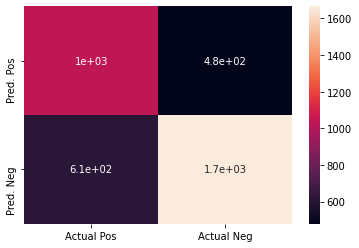

In [ ]:
tp = 0
fp = 0
tn = 0
fn = 0
for i in range(len(validation_data)):
  tmr_rain = validation_data.iloc[i]['TMRW_RAIN']
  pred = logit_pred[i]
  if tmr_rain == 1 and pred == 1:
      tp = tp + 1
  elif tmr_rain == 0 and pred == 1:
      fp = fp + 1
  elif tmr_rain == 0 and pred == 0:
      tn = tn + 1
  else:
      fn = fn + 1
plot_confusion_matrix(tp, fp, fn, tn)
print(tp, fp, tn, fn)

# ROC curve
In this section, we will visualize the ROC curves of the classfiers above on the same plot.

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score

In [ ]:
classifiers = [LogisticRegression(random_state = 1), 
               KNeighborsClassifier(),
               DecisionTreeClassifier(random_state = 1),
               RandomForestClassifier(random_state = 1)]
result_table = pd.DataFrame(columns = ['classifiers', 'fpr', 'tpr', 'auc'])
for cls in classifiers: 
  model = cls.fit(train_data[features], train_data[target])
  ypred = model.predict_proba(validation_data[features])[::, 1]

  fpr, tpr, _ = roc_curve(validation_data[target], ypred)
  auc = roc_auc_score(validation_data[target], ypred)

  result_table = result_table.append({'classifiers':cls.__class__.__name__,
                                        'fpr':fpr, 
                                        'tpr':tpr, 
                                        'auc':auc}, ignore_index=True)
  
  # set names of the classifiers for the legends
result_table.set_index('classifiers', inplace = True)

Then, we will draw the ROC curve.

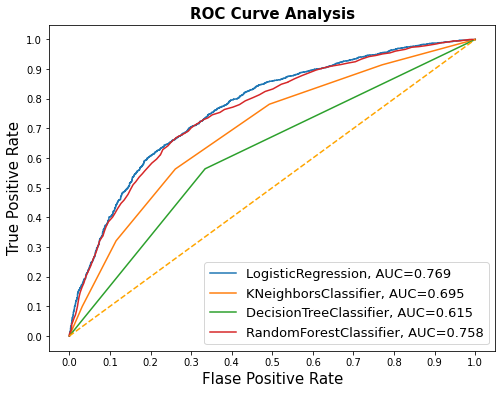

In [ ]:
fig = plt.figure(figsize=(8,6))

for i in result_table.index:
    plt.plot(result_table.loc[i]['fpr'], 
             result_table.loc[i]['tpr'], 
             label="{}, AUC={:.3f}".format(i, result_table.loc[i]['auc']))
    
plt.plot([0,1], [0,1], color='orange', linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("Flase Positive Rate", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15)

plt.title('ROC Curve Analysis', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13}, loc='lower right')

plt.show()

### Discussion

* Briefly discuss what you are inferring from this plot

In the ROC plot below, Logistic Regression and Random forest classifier have higher area under curve, which means they have better accuracy in predicting rain in the future. Thus, the model with the highest validation accuracy is logistic regression, our final model.

* Briefly discuss what features you used and whether you did some transformations on them. Why?

We did not use date because it is not a numerical feature nor a meaningful categorical feature. Also, at first we used tmrw_prcp as feature, but it result in accuracy of 1.0 for decision tree and random forest classifier. We thought it didn't make sense to include it as feature since we do not know the future percipitation. 

* What features seemed important for your final model?

We print all the coefficients for the logistic regression model and find the largest coefficients are, whether today rains, past 30 days precipitation, and today's precipitation. 

* Explain how you set up your validation.

At first, we split data into 0.2 and 0.8 as validation and test set, then use the training model to predict the validation dataset, then pick the one with the higherst validation accuracy.

* Explain what did you do to improve your initial predictions. Did it help?

As for decision tree model, we use gridsearch to find the best parameters and it did improve the accuray of the original decision tree, then we use random forest classifier to make more robust prediction.